# xFLS master catalogue
## Preparation of KPNO-FLS data

Isaac Newton Telescope / Wide Field Camera (INT/WFC) catalogue: the catalogue comes from `dmu0_KPNO-FLS`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The aperture magnitude;
- The total magnitude.

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "kpno_ra"
DEC_COL = "kpno_dec"

## I - Column selection

In [9]:
imported_columns = OrderedDict({
        'internal_id': "kpno_intid",
        'RAJ2000': "kpno_ra",
        'DEJ2000': "kpno_dec",
        'Class':  "kpno_stellarity",
        'RcmagAp': "m_ap_kpno_r", 
        'e_RcmagAp': "merr_ap_kpno_r", 
        'RcmagTot': "m_kpno_r", 
        'e_RcmagTot': "merr_kpno_r",
    })


catalogue = Table.read("../../dmu0/dmu0_KPNO-FLS/data/KPNO-FLS_xFLS.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011

# Clean table metadata
catalogue.meta = None

In [10]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:]) 

        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [11]:
catalogue[:10].show_in_notebook()

idx,kpno_intid,kpno_ra,kpno_dec,kpno_stellarity,m_ap_kpno_r,merr_ap_kpno_r,m_kpno_r,merr_kpno_r,f_ap_kpno_r,ferr_ap_kpno_r,f_kpno_r,ferr_kpno_r,flag_kpno_r
,,deg,deg,,mag,mag,mag,mag,,,,,
0,1,258.018795833,59.6362777778,0.368,23.71,0.11,23.12,0.13,1.19124,0.120689,2.05116,0.245594,False
1,2,258.0183,59.6358472222,0.307,23.43,0.08,22.47,0.11,1.5417,0.113597,3.7325,0.378154,False
2,3,258.020195833,59.6356472222,0.055,21.88,0.02,21.49,0.03,6.42688,0.118387,9.20449,0.254329,False
3,4,258.0507,59.6369083333,0.854,24.17,0.16,23.58,0.19,0.77983,0.11492,1.34276,0.234979,False
4,5,257.9012,59.6356083333,0.63,24.6,0.25,24.56,0.17,0.524807,0.120841,0.544503,0.085256,False
5,6,258.0667,59.6368888889,0.982,22.82,0.04,22.8,0.04,2.70396,0.0996175,2.75423,0.10147,False
6,7,257.9642,59.6354277778,0.029,21.41,0.01,20.76,0.02,9.90832,0.091259,18.0302,0.332128,False
7,8,258.0692,59.6377083333,0.911,24.2,0.08,24.2,0.08,0.758577,0.055894,0.758577,0.055894,False
8,9,258.105,59.6380583333,0.9,23.76,0.11,23.68,0.19,1.13763,0.115257,1.22462,0.214303,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [12]:
SORT_COLS = ['merr_ap_kpno_r']
FLAG_NAME = 'kpno_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 722525 sources.
The cleaned catalogue has 670834 sources (51691 removed).
The cleaned catalogue has 50496 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [13]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_xFLS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

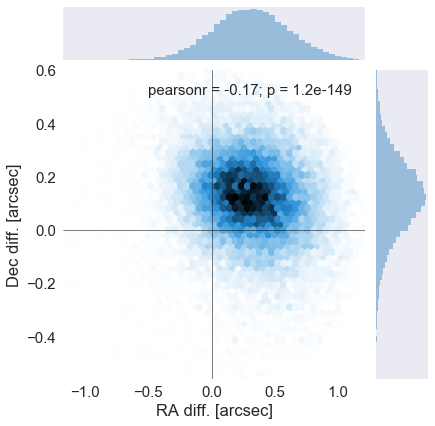

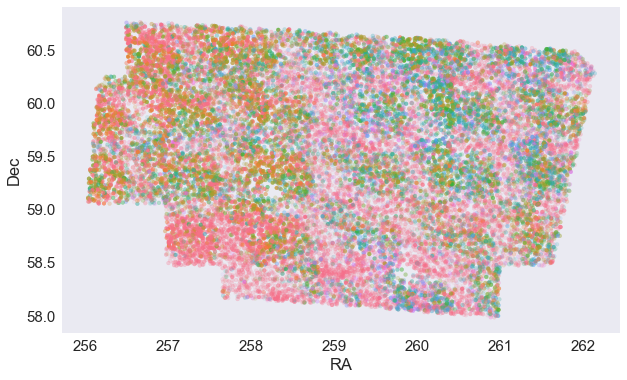

In [14]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [15]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.3095527144182597 arcsec
Dec correction: -0.12726026545522018 arcsec


In [18]:
catalogue[RA_COL] =  catalogue[RA_COL] + delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL]  + delta_dec.to(u.deg)

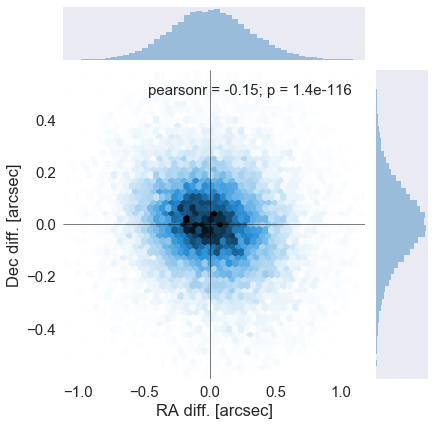

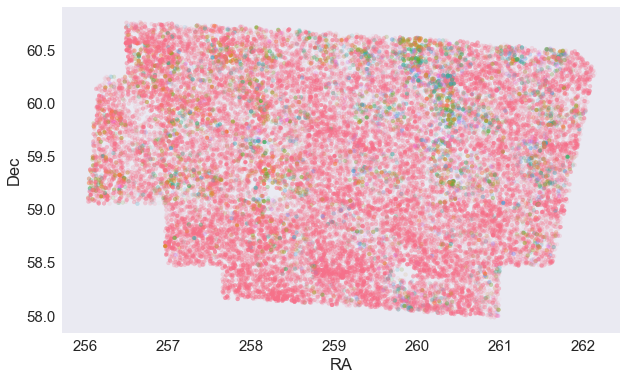

In [19]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [20]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [21]:
GAIA_FLAG_NAME = "kpno_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

24932 sources flagged.


# V - Saving to disk

In [22]:
catalogue.write("{}/KPNO.fits".format(OUT_DIR), overwrite=True)